In [1]:
from IPython.display import Math
 
# Manipulação dos dados
import numpy as np
import pandas as pd
 
# Gráficos
import matplotlib as mpl
import matplotlib.pyplot as plt
 
import seaborn as sns
sns.set_theme()

In [2]:
# Ajustes nas configurações padrões dos plots
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [3]:
# #https://gpflow.readthedocs.io/en/master/notebooks/basics/GPLVM.html

# import gpflow
# import numpy as np

# import matplotlib.pyplot as plt
# import tensorflow as tf

# import gpflow
# from gpflow.utilities import ops, print_summary
# from gpflow.config import set_default_float, default_float, set_default_summary_fmt
# from gpflow.ci_utils import ci_niter

# #set_default_float(np.float64)
# set_default_float(np.float32)
# set_default_summary_fmt("notebook")


In [4]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv', index_col=0)

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

In [5]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [6]:
cidade = dataset[['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte']]
cidade = cidade * (1, 2, 3, 4, 5)
cidade = cidade.sum(axis=1) - 1
cidade = cidade.values.reshape((-1, 1))

#labels = tf.convert_to_tensor(cidade, dtype=default_float())

In [7]:
#Y = tf.convert_to_tensor(X, dtype=default_float())

In [8]:
#print("Number of points: {} and Number of dimensions: {}".format(Y.shape[0], Y.shape[1]))

In [9]:
# latent_dim = 2  # number of latent dimensions
# num_inducing = 20  # number of inducing pts
# num_data = Y.shape[0]  # number of data points

In [10]:
# X_mean_init = ops.pca_reduce(Y, latent_dim)
# X_var_init = tf.ones((num_data, latent_dim), dtype=default_float())

In [11]:
# np.random.seed(1)  # for reproducibility
# inducing_variable = tf.convert_to_tensor(
#     np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
# )

In [12]:
# lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
# kernel = gpflow.kernels.RBF(lengthscales=lengthscales)

# gplvm = gpflow.models.BayesianGPLVM(
#     Y,
#     X_data_mean=X_mean_init,
#     X_data_var=X_var_init,
#     kernel=kernel,
#     inducing_variable=inducing_variable,
# )
# # Instead of passing an inducing_variable directly, we can also set the num_inducing_variables argument to an integer, which will randomly pick from the data.

# gplvm.likelihood.variance.assign(0.01)

In [13]:
# opt = gpflow.optimizers.Scipy()
# maxiter = ci_niter(1000)

# _ = opt.minimize(
#     gplvm.training_loss,
#     method="BFGS",
#     variables=gplvm.trainable_variables,
#     options=dict(maxiter=maxiter),
# )

In [14]:
# print_summary(gplvm)

In [15]:
# X_pca = ops.pca_reduce(Y, latent_dim).numpy()
# gplvm_X_mean = gplvm.X_data_mean.numpy()

# f, ax = plt.subplots(1, 2, figsize=(10, 6))

# for i in np.unique(labels):
#     ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
#     ax[1].scatter(gplvm_X_mean[labels == i, 0], gplvm_X_mean[labels == i, 1], label=i)
#     ax[0].set_title("PCA")
#     ax[1].set_title("Bayesian GPLVM")

In [16]:
#https://gpy.readthedocs.io/en/deploy/GPy.models.html
# !pip install gpy

In [17]:
from GPy.models.bayesian_gplvm import BayesianGPLVM
from GPy.models.bayesian_gplvm_minibatch import BayesianGPLVMMiniBatch

# Fazer subamostragem aleatória
# 50
# Projeção com VAE

#gplvm = BayesianGPLVM(Y=X, input_dim=3, init='PCA', num_inducing=50)
gplvm = BayesianGPLVMMiniBatch(Y=X, input_dim=3, init='PCA', num_inducing=50)
gplvm

bayesian_gplvm.,value,constraints,priors
latent space.mean,"(10688, 3)",,
latent space.variance,"(10688, 3)",+ve,
inducing inputs,"(50, 3)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [18]:
gplvm.optimize(messages='verbose', max_f_eval=2)

{'scatter': {'inducing': <matplotlib.collections.PathCollection at 0x7f3dd14fcb20>}}

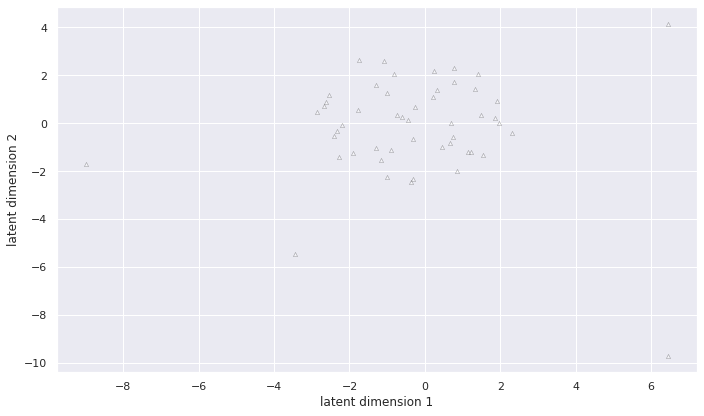

In [19]:
gplvm.plot_inducing()

{'scatter': [<matplotlib.collections.PathCollection at 0x7f3de3c27070>,
 'imshow': <matplotlib.image.AxesImage at 0x7f3de3c33310>}

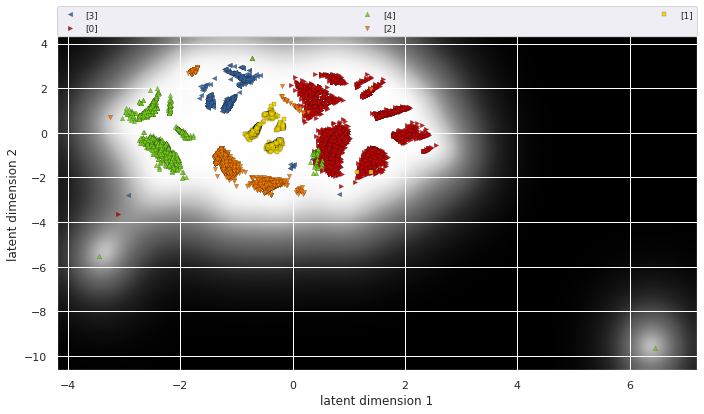

In [20]:
gplvm.plot_latent(labels=cidade, num_samples=len(X))

 /home/paulo/git/doutorado/aprendizagem-probabilistica/topicosTrabalhoFinal/venv/lib/python3.8/site-packages/GPy/plotting/matplot_dep/util.py:38: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'scatter': [<mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7f3de2324b20>,
  <mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7f3de2334b20>]}

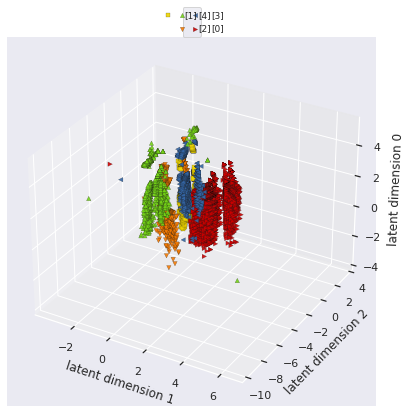

In [21]:
gplvm.plot_scatter(labels=cidade, num_samples=len(X), projection='3d')

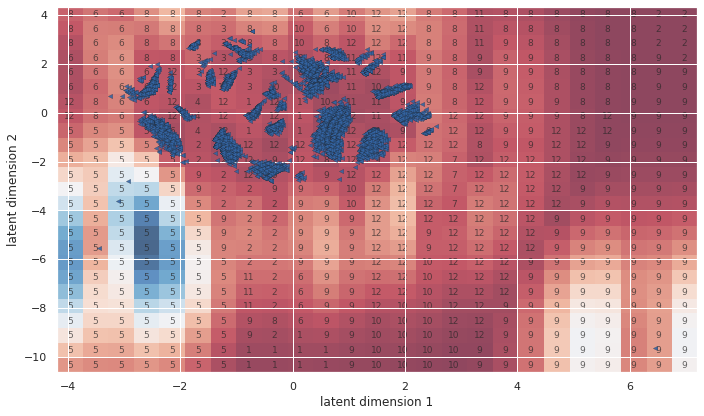

In [22]:
gplvm.plot_steepest_gradient_map(num_samples=len(X), resolution=25);

In [ ]:
# São paulo: triângulo
# Resto: bolinha
# 